# Project: FRED Data Analysis and Storage in PostgreSQL
This project involves fetching economic data from the FRED (Federal Reserve Economic Data) API, processing it, storing it in a PostgreSQL database, and then doing a time series analysis. 

## I want to gain experience using Arima and Prophet models and I also want to create a full scale project


# 1. Fetching Data from FRED API
Description
In this section, we define a function to search for economic data series in the FRED API based on specific search terms. The function filters the results to include only US-related series and returns a list of series names and IDs.


In [1]:
import requests
import urllib.parse

def get_series_data(search_text, api_key):
   
    encoded_search_text = urllib.parse.quote(search_text)
    
   
    search_url = f"https://api.stlouisfed.org/fred/series/search?search_text={encoded_search_text}&api_key={api_key}&file_type=json"
    response = requests.get(search_url)
    
  
    if response.status_code == 200:
        data = response.json()
        series_list = data.get("seriess", [])
        
        # Filtering for US-related series 
        us_series_list = [series for series in series_list if 'US' in series['title']]

        # Creating a list to store series names and ids
        series_info = []
        
        for series in us_series_list:
            series_info.append((series['title'], series['id']))
        
        return series_info
    
    else:
        print(f"Error: {response.status_code}")
        return None



api_key = '0d10f492049f3de481ba7fa08448bf21'


search_terms = [
    "Exports of Goods and Services",
    "Imports of Goods and Services",
    "Net Exports (Exports - Imports)",
    "Current Account Balance",
    "Capital Account Balance",
    "Financial Account Balance",
    "Foreign Direct Investment (FDI)",
    "Portfolio Investment",
    "Reserve Assets",
    "Trade Balance"
]


all_series_info = {}


for term in search_terms:
    print(f"Fetching data for: {term}")
    series_info = get_series_data(term, api_key)
    
    
    if series_info:
        all_series_info[term] = series_info


for term, series_list in all_series_info.items():
    print(f"\nSeries for: {term}")
    for series_name, series_id in series_list:
        print(f"Series Name: {series_name}, Series ID: {series_id}")


Fetching data for: Exports of Goods and Services
Fetching data for: Imports of Goods and Services
Fetching data for: Net Exports (Exports - Imports)
Fetching data for: Current Account Balance
Fetching data for: Capital Account Balance
Fetching data for: Financial Account Balance
Fetching data for: Foreign Direct Investment (FDI)
Fetching data for: Portfolio Investment
Fetching data for: Reserve Assets
Fetching data for: Trade Balance

Series for: Portfolio Investment
Series Name: US Acquisition of Portfolio Investment Assets, Series ID: IEAAPI
Series Name: US Acquisition of Portfolio Investment Assets, Series ID: IEAAPIA
Series Name: US Acquisition of Portfolio Investment Assets, Series ID: IEAAPIN
Series Name: AD&Co US Mortgage High Yield Index, Credit-and-Option-Adjusted Spread: Mid-Tier, Series ID: CROASMIDTIER
Series Name: US Incurrence of Portfolio Investment Liabilities: Equity and investment fund shares, Series ID: IEAIPIE
Series Name: US Incurrence of Portfolio Investment Liabi

# 2. Fetching Data for Specific Series
Description
In this section, we define a function to fetch time series data for specific series IDs from the FRED API. The function retrieves observations (data points) for each series and organizes them into a structured DataFrame.

In [2]:
import pandas as pd
import requests


api_key = "0d10f492049f3de481ba7fa08448bf21"
file_type = "json"
observation_start = "2000-01-01"
observation_end = "2024-12-31"
limit = 1000
frequency = "m"  # monthly data
sort_order = "asc"


portfolio_investment_assets_series_ids = [
    "IEAAPI", "IEAAPIA", "IEAAPIN", "CROASMIDTIER", "IEAIPIE", "IEAIPIEN", "IEAAPIE", "IEAIPIEA", 
    "IEAAPIEA", "IEAAPIEN", "IEAIPI", "IEAIPIN", "IEAIPIA", "IEAIPID", "IEAIPIDN", "IEAAPID", 
    "IEAAPIDA", "IEAIPIDA", "IEAAPIDN", "CROASTIER0", "CROASTIER1", "CRTINDEXTIER1", "CROASTIER3", 
    "CROASTIER2", "CRTINDEXTIER0", "CRTINDEXTIER3", "CRTINDEXTIER2", "CRTINDEXMIDTIER"
]

reserve_assets_series_ids = [
    "IEAARM", "IEAARMN", "IEAARMA", "IEAARON", "IEAARO", "IEAARIMF", "IEAARIMFN", "IEAARIMFA", 
    "IEAAR", "IEAARN", "IEAARA", "IEAAORO", "IEAAORON", "IEAARSD", "IEAAS", "IEAAFDN", "IEAAFD", 
    "IEAAFDA", "IEAACDN", "IEAACD", "IEAAROA", "IEAAOROA", "IEAARSDA", "IEAARSDN", "IEAASA", 
    "IEAASN", "IEAACDA"
]

series_id_to_name = {
    "IEAAPI": "Portfolio Investment Assets",
    "IEAAPIA": "Portfolio Investment Assets - A",
    "IEAAPIN": "Portfolio Investment Assets - N",
    "CROASMIDTIER": "Portfolio Investment Assets - Tier 1",
    "IEAIPIE": "Portfolio Investment Assets - PIE",
    "IEAIPIEN": "Portfolio Investment Assets - PIE N",
    "IEAAPIE": "Portfolio Investment Assets - PIE All",
    "IEAIPIEA": "Portfolio Investment Assets - PIE A",
    "IEAAPIEA": "Portfolio Investment Assets - PIE A All",
    "IEAAPIEN": "Portfolio Investment Assets - PIE EN",
    "IEAIPI": "Portfolio Investment Assets - PI",
    "IEAIPIN": "Portfolio Investment Assets - PIN",
    "IEAIPIA": "Portfolio Investment Assets - PIA",
    "IEAIPID": "Portfolio Investment Assets - PID",
    "IEAIPIDN": "Portfolio Investment Assets - PIDN",
    "IEAAPID": "Portfolio Investment Assets - AID",
    "IEAAPIDA": "Portfolio Investment Assets - AIDA",
    "IEAIPIDA": "Portfolio Investment Assets - PIDA",
    "IEAAPIDN": "Portfolio Investment Assets - AIDN",
    "CROASTIER0": "Reserve Assets - Tier 0",
    "CROASTIER1": "Reserve Assets - Tier 1",
    "CRTINDEXTIER1": "Reserve Assets - CRT Tier 1",
    "CROASTIER3": "Reserve Assets - Tier 3",
    "CROASTIER2": "Reserve Assets - Tier 2",
    "CRTINDEXTIER0": "Reserve Assets - CRT Tier 0",
    "CRTINDEXTIER3": "Reserve Assets - CRT Tier 3",
    "CRTINDEXTIER2": "Reserve Assets - CRT Tier 2",
    "CRTINDEXMIDTIER": "Reserve Assets - CRT Mid Tier",
    "IEAARM": "Reserve Assets - ARM",
    "IEAARMN": "Reserve Assets - ARM N",
    "IEAARMA": "Reserve Assets - ARMA",
    "IEAARON": "Reserve Assets - ARON",
    "IEAARO": "Reserve Assets - ARO",
    "IEAARIMF": "Reserve Assets - ARIMF",
    "IEAARIMFN": "Reserve Assets - ARIMFN",
    "IEAARIMFA": "Reserve Assets - ARIMFA",
    "IEAAR": "Reserve Assets - AR",
    "IEAARN": "Reserve Assets - ARN",
    "IEAARA": "Reserve Assets - ARA",
    "IEAAORO": "Reserve Assets - AORO",
    "IEAAORON": "Reserve Assets - AORON",
    "IEAARSD": "Reserve Assets - ARSD",
    "IEAAS": "Reserve Assets - AS",
    "IEAAFDN": "Reserve Assets - AFDN",
    "IEAAFD": "Reserve Assets - AFD",
    "IEAAFDA": "Reserve Assets - AFDA",
    "IEAACDN": "Reserve Assets - AACDN",
    "IEAACD": "Reserve Assets - AACD",
    "IEAAROA": "Reserve Assets - AROA",
    "IEAAOROA": "Reserve Assets - AOROA",
    "IEAARSDA": "Reserve Assets - ARSDA",
    "IEAARSDN": "Reserve Assets - ARSDN",
    "IEAASA": "Reserve Assets - ASA",
    "IEAASN": "Reserve Assets - ASN",
    "IEAACDA": "Reserve Assets - AACDA"
}

# Function to fetch data 
def fetch_data_for_series(series_id):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type={file_type}&observation_start={observation_start}&observation_end={observation_end}&limit={limit}&frequency={frequency}&sort_order={sort_order}"
    
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        observations = data.get("observations", [])
        
       
        data_list = []
        for obs in observations:
            series_name = series_id_to_name.get(series_id, "Unknown Series")  # Get the series name
            data_list.append({
                "Series_Name": series_name,
                "Series_ID": series_id,
                "Date": obs["date"],
                "Value": obs["value"]
            })
        
        # Convert to DataFrame
        df = pd.DataFrame(data_list)
        return df
    else:
        print(f"Failed to retrieve data for series ID {series_id}: {response.status_code}")
        return pd.DataFrame()


dfs = []
for series_id in portfolio_investment_assets_series_ids + reserve_assets_series_ids:
    df = fetch_data_for_series(series_id)
    if not df.empty:
        dfs.append(df)


final_df = pd.concat(dfs, ignore_index=True)


print(final_df)

Failed to retrieve data for series ID IEAAPI: 400
Failed to retrieve data for series ID IEAAPIA: 400
Failed to retrieve data for series ID IEAAPIN: 400
Failed to retrieve data for series ID IEAIPIE: 400
Failed to retrieve data for series ID IEAIPIEN: 400
Failed to retrieve data for series ID IEAAPIE: 400
Failed to retrieve data for series ID IEAIPIEA: 400
Failed to retrieve data for series ID IEAAPIEA: 400
Failed to retrieve data for series ID IEAAPIEN: 400
Failed to retrieve data for series ID IEAIPI: 400
Failed to retrieve data for series ID IEAIPIN: 400
Failed to retrieve data for series ID IEAIPIA: 400
Failed to retrieve data for series ID IEAIPID: 400
Failed to retrieve data for series ID IEAIPIDN: 400
Failed to retrieve data for series ID IEAAPID: 400
Failed to retrieve data for series ID IEAAPIDA: 400
Failed to retrieve data for series ID IEAIPIDA: 400
Failed to retrieve data for series ID IEAAPIDN: 400
Failed to retrieve data for series ID IEAARM: 400
Failed to retrieve data fo

# 4. Storing Data in PostgreSQL
Description
In this section, we store the combined DataFrame (final_df) into a PostgreSQL database. We use the sqlalchemy library to connect to the database and insert the data into a table.



In [3]:
# storing final df to postgres

!pip install sqlalchemy psycopg2


import pandas as pd
from sqlalchemy import create_engine





db_config = {
    'dbname': 'pg4e_96c46dbe33',  
    'user': 'pg4e_96c46dbe33',         
    'password': 'pg4e_p_4984e3e88e36654',     
    'host': 'pg.pg4e.com',             
    'port': '5432'              
}


connection_string = f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"


engine = create_engine(connection_string)


table_name = 'FRED_DATA'  
final_df.to_sql(table_name, engine, if_exists='replace', index=False)

print(f"DataFrame successfully inserted into table '{table_name}'.")




DataFrame successfully inserted into table 'FRED_DATA'.


# 5. Time Series Analysis and Forecasting
Description
In this section, we perform time series analysis and forecasting on the portfolio investment assets data. We use both ARIMA and Prophet models to forecast future values and evaluate their performance.
I chose to look at Portfolio Investment Assets which has the series id:'CROASMIDTIER'.


In [4]:
!pip install prophet

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prophet import Prophet



final_df['Date'] = pd.to_datetime(final_df['Date'])


final_df.set_index('Date', inplace=True)


portfolio_df = final_df[final_df['Series_ID'] == 'CROASMIDTIER']  


portfolio_df = portfolio_df.resample('M').mean()

portfolio_df.fillna(method='ffill', inplace=True)

portfolio_df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 163.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 163.8 MB/s eta 0:00:00


Importing plotly failed. Interactive plots will not work.


,Value
Date,
2015-06-30,361.589251
2015-07-31,386.876042
2015-08-31,404.517020
2015-09-30,414.190847
2015-10-31,433.302898


# 6. Exploratory Data Analysis (EDA)
Description
In this section, we visualize the time series data and decompose it into trend, seasonal, and residual components to understand its structure.

Code

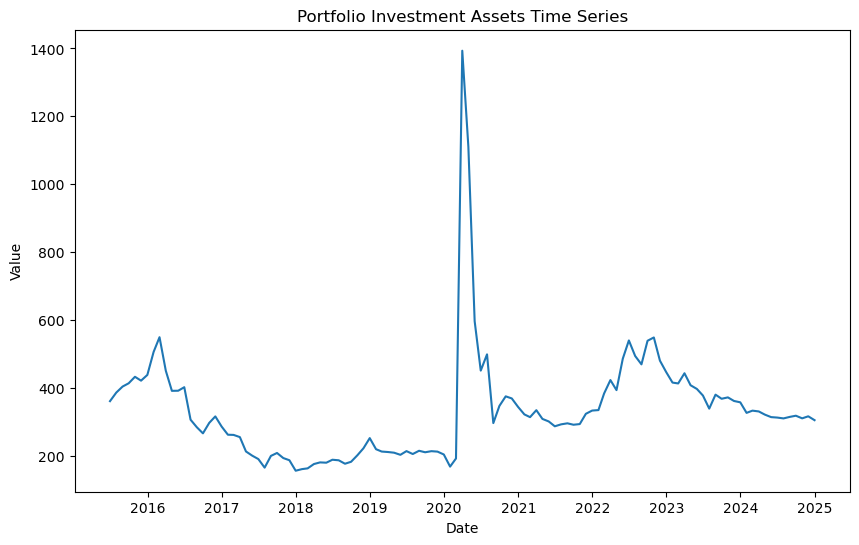

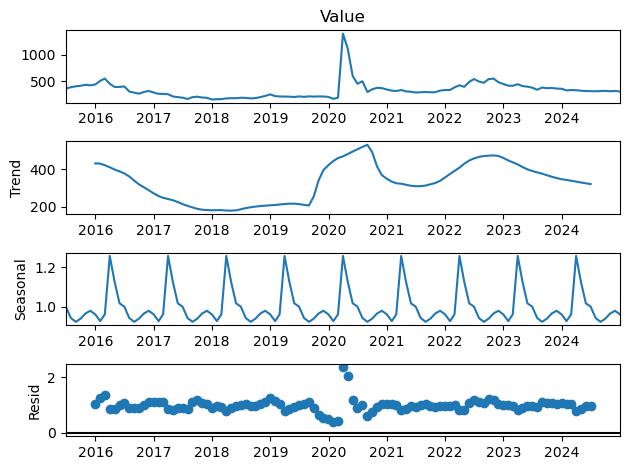

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_df['Value'])
plt.title('Portfolio Investment Assets Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(portfolio_df['Value'], model='multiplicative')


decomposition.plot()
plt.show()

# 7 ARIMA Model & Prophet model for time series forecasting. 
ARIMA Model:
- Description
    - In this section, we build and evaluate an ARIMA model for time series forecasting. Key steps include:

    - Splitting the data into training and test sets.

    - Fitting an ARIMA model with specified parameters (p, d, q).

    - Making predictions on the test set.

    - Evaluating the model using Mean Absolute Percentage Error (MAPE) and Root Mean Squared Error (RMSE).
Prophet Model:
- Description
    - Preparing the data for Prophet (renaming columns to ds and y).

    - Splitting the data into training and test sets.

    - Fitting a Prophet model.

    - Making predictions on the test set.

    - Evaluating the model using MAPE and RMSE.

10:52:28 - cmdstanpy - INFO - Chain [1] start processing


ARIMA Model - MAPE: 0.3132864688025159
ARIMA Model - RMSE: 111.60893277763435


10:52:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model - MAPE: 0.3839051715234335
Prophet Model - RMSE: 155.71602390615806


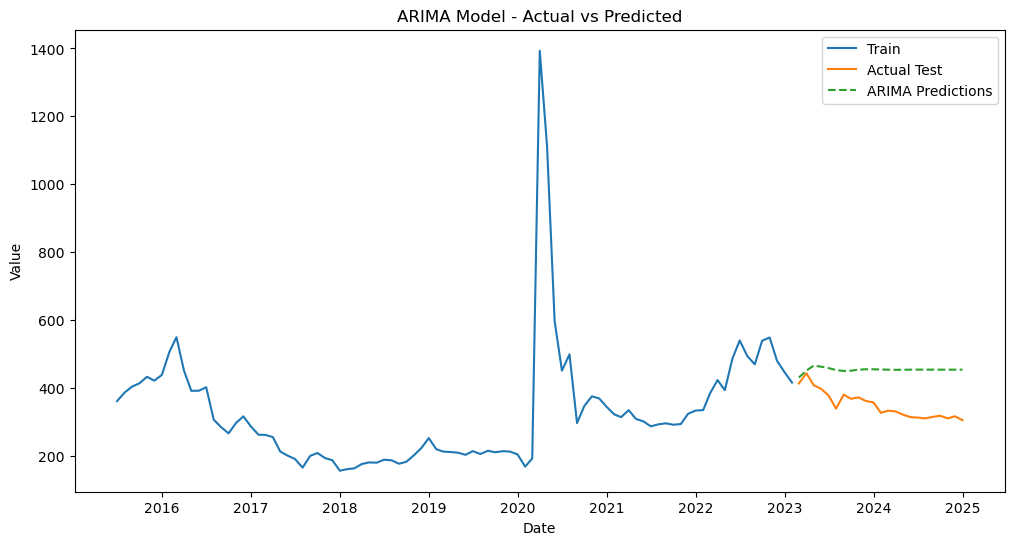

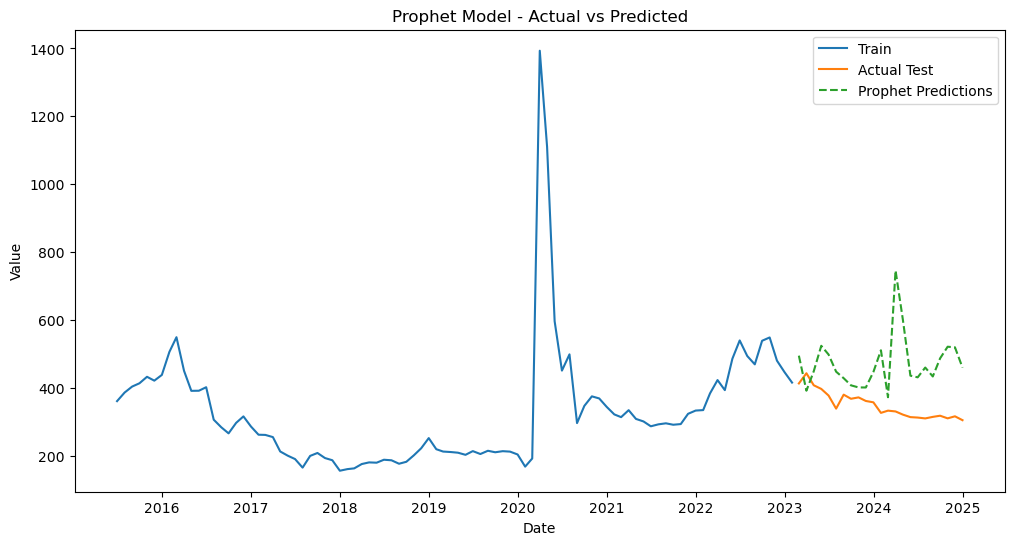

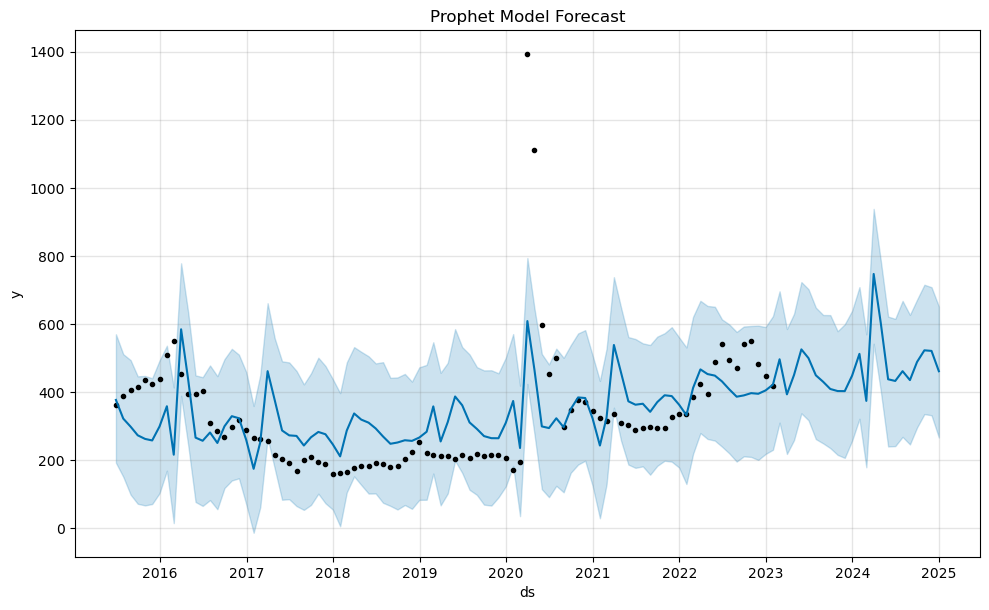

In [6]:
train_size = int(len(portfolio_df) * 0.8)
train_arima, test_arima = portfolio_df[:train_size], portfolio_df[train_size:]

# Fit an ARIMA model (adjust p, d, q as needed)
arima_model = ARIMA(train_arima['Value'], order=(5, 1, 0))  # Example parameters
arima_model_fit = arima_model.fit()

# Make predictions on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_arima))

# Evaluate the model using MAPE and RMSE
mape_arima = mean_absolute_percentage_error(test_arima['Value'], arima_predictions)
rmse_arima = mean_squared_error(test_arima['Value'], arima_predictions, squared=False)

print(f'ARIMA Model - MAPE: {mape_arima}')
print(f'ARIMA Model - RMSE: {rmse_arima}')


prophet_df = portfolio_df.reset_index()[['Date', 'Value']]
prophet_df.columns = ['ds', 'y']

# Split into training and test sets 
train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df[:train_size]
test_prophet = prophet_df[train_size:]

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Create a future dataframe for forecasting 
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='M')

# Generate the forecast
forecast = prophet_model.predict(future)

# Evaluate the Prophet model by comparing actual vs forecasted values
prophet_predictions = forecast['yhat'][-len(test_prophet):].values

# Evaluate using MAPE and RMSE
mape_prophet = mean_absolute_percentage_error(test_prophet['y'], prophet_predictions)
rmse_prophet = mean_squared_error(test_prophet['y'], prophet_predictions, squared=False)


print(f'Prophet Model - MAPE: {mape_prophet}')
print(f'Prophet Model - RMSE: {rmse_prophet}')


# Plot Actual vs Predicted (ARIMA)
plt.figure(figsize=(12, 6))
plt.plot(train_arima.index, train_arima['Value'], label='Train')
plt.plot(test_arima.index, test_arima['Value'], label='Actual Test')
plt.plot(test_arima.index, arima_predictions, label='ARIMA Predictions', linestyle='--')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot Actual vs Predicted (Prophet)
plt.figure(figsize=(12, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test')
plt.plot(test_prophet['ds'], prophet_predictions, label='Prophet Predictions', linestyle='--')
plt.title('Prophet Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the forecasted values from Prophet
prophet_model.plot(forecast)
plt.title('Prophet Model Forecast')
plt.show()

## Conclusion
The ARIMA model outperformed the Prophet model in terms of both accuracy and predictive performance. Specifically, the ARIMA model achieved a MAPE of 31.33% and RMSE of 111.61, indicating it made more accurate forecasts with lower error. In comparison, the Prophet model had a MAPE of 38.39% and RMSE of 155.72, which suggests its predictions were less accurate. Overall, ARIMA provided more reliable results for forecasting future portfolio investment and reserve assets.







